In [2794]:
from __future__ import division, print_function

# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')
%matplotlib inline

# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
#import superfreq
#plt.style.use('apw-notebook')
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.util import rolling_window
from scipy.signal import argrelmin,argrelmax
from scipy.stats import scoreatpercentile
from scipy.integrate import quad
from matplotlib import cm
import ophiuchus.potential as op

x = gp.SphericalNFWPotential
print(x)
#Data to see if stream matches observed quantities 
obs_oden = np.genfromtxt('../Pal5Bar_copy/obs_RA.txt') 
OD = np.genfromtxt('../Pal5Bar_copy/OD_radec.txt')

<class 'gala.potential.potential.builtin.cybuiltin.SphericalNFWPotential'>


In [2795]:
halo_pars_reg = dict()
halo_pars_reg['c'] = 0.94 # Bovy 2016
M_h_reg = 5e11 *u.Msun# Bovy 2012 https://arxiv.org/pdf/1209.0759v1.pdf
rs_h_reg = 18. * u.kpc # Bovy 2016
v_c_reg = np.sqrt(((np.log(2.) - 0.5) * (G * M_h_reg / rs_h_reg)).decompose(galactic).value)
halo_pars_reg['r_s'] = rs_h_reg
halo_pars_reg['v_c'] = v_c_reg


mw_potential_reg = gp.CCompositePotential()
mw_potential_reg['halo'] = gp.NFWPotential(units=galactic, **halo_pars_reg)
mw_potential_reg['disk'] = gp.MiyamotoNagaiPotential(m=7.5e10*u.Msun, a=3, b=0.28,
                                                     units=galactic)
mw_potential_reg['spheroid'] = gp.HernquistPotential(m=5e9, c=10., units=(u.kpc,u.Myr,u.Msun,u.radian))


pot_reg = mw_potential_reg

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: NFWPotential now expects a scale mass in the default initializer. To initialize from a circular velocity, use the classmethod from_circular_velocity() instead instead.
  # This is added back by InteractiveShellApp.init_path()


In [2796]:
# Setting Sun's params - should update distance
v_lsr = [11.1, 24.0, 7.25]*u.km/u.s
v_circ = 220*u.km/u.s
galcen_frame = coord.Galactocentric(galcen_distance=8.*u.kpc)
sun_frame = dict(vlsr=v_lsr, vcirc=v_circ, galactocentric_frame=galcen_frame)

In [2797]:
#Use Astropy to do this instead

v_sun = coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame = coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)

#c = #coordinates of all my "model points" - both leading trailing

pal5_c = coord.SkyCoord(ra=229.018*u.degree, dec=-0.124*u.degree,
                   distance=22.9*u.kpc,
                   pm_ra_cosdec=-2.296*u.mas/u.yr,
                   pm_dec=-2.257*u.mas/u.yr,
                   radial_velocity=-58.7*u.km/u.s)

w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)

In [2798]:
orbit_reg = pot_reg.integrate_orbit(w0, dt=-0.5, n_steps=8000, Integrator=gi.DOPRI853Integrator)


forw_orbit_reg = orbit_reg[::-1]


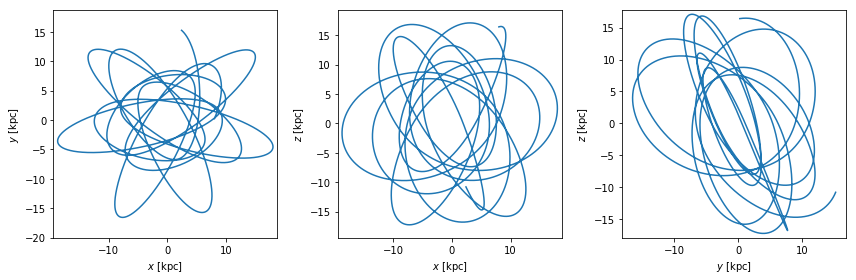

In [2799]:
_ = orbit.plot(marker='')

In [2800]:
stream_reg = gd.mockstream.fardal_stream(pot_reg, forw_orbit_reg, 5E4*u.Msun, release_every=8)


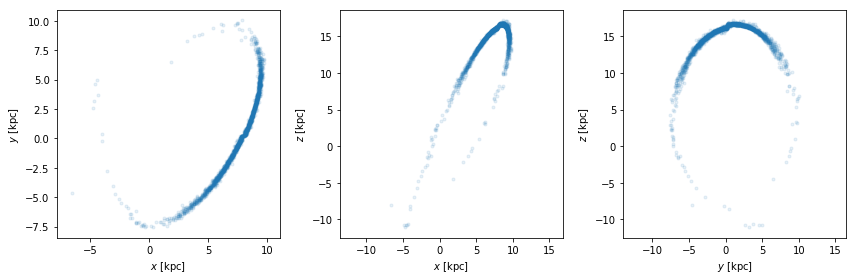

In [2801]:
_ = stream_reg.plot(marker='.', alpha=0.1)


## Project to tangent plane

In [2802]:
galcen_frame = coord.Galactocentric(z_sun=0*u.kpc, galcen_distance=8.1*u.kpc)
sim_c = stream_reg.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)

In [2803]:
ra_reg =  sim_c.ra
dec_reg = sim_c.dec

In [2804]:
from astropy.wcs import WCS

def get_projected_coords(c, pal5_c):
    """
    Parameters
    ----------
    c : astropy SkyCoord object
        The coordinates that you want to project
    pal5_c : astropy SkyCoord object
        The coordinates of Pal 5 the cluster
    """
    offset_fr = coord.SkyOffsetFrame(origin=pal5_c)
    c2 = c.transform_to(offset_fr)

    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [0., 0.]
    wcs.wcs.cdelt = [1., 1.]
    wcs.wcs.crval = [0, 0]
    wcs.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]

    return wcs.wcs_world2pix(c2.lon.degree, c2.lat.degree, 0)

In [2805]:
stream_proj = get_projected_coords(sim_c, pal5_c)
stream_proj_x = stream_proj[0]
stream_proj_y = stream_proj[1]

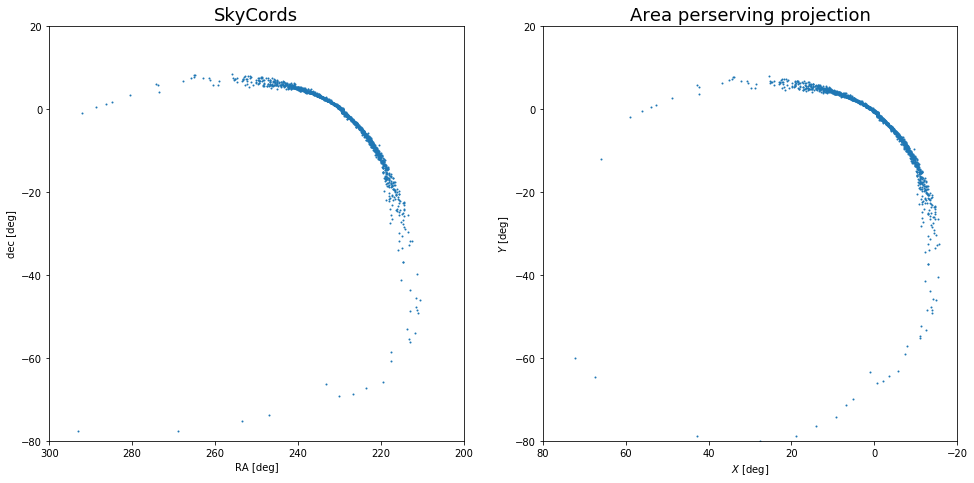

In [2806]:
fig,axes = plt.subplots(1,2,figsize=(14,7))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 22})

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[0].set_xlim(300,200)
axes[1].set_xlim(80,-20)
axes[0].set_ylim(-80,20)
axes[1].set_ylim(-80,20)

axes[0].set_title('SkyCords', fontsize=18)
axes[0].scatter(ra_reg, dec_reg, s=1)
axes[0].set_xlabel('RA [deg]')
axes[0].set_ylabel('dec [deg]')

axes[1].set_title('Area perserving projection', fontsize=18)
axes[1].scatter(stream_proj_x,stream_proj_y, s=1)
axes[1].set_xlabel('$X$ [deg]')
axes[1].set_ylabel('$Y$ [deg]')

fig.tight_layout()

## Fit polynomial to leading and trailing arm
Using new are perserving coordinate system

In [2807]:
#First sort data pased on "X" coord. 

stream_proj_x_sort = np.sort(stream_proj_x)
#stream_proj_y_sort = np.sort(stream_proj_y)
inds = stream_proj_x.argsort()
stream_proj_y_sort = stream_proj_y[inds]

In [2808]:
#Gotta sort sim data. and separate into leading trailing particles based on prog. position 

sim_lead_index = np.where((stream_proj_y_sort < -1) & (stream_proj_x_sort < 20)& (stream_proj_y_sort > -40))
sim_trail_index = np.where((stream_proj_y_sort > -1))



In [2809]:
polyfit_lead = np.polyfit(stream_proj_x_sort[sim_lead_index] , stream_proj_y_sort[sim_lead_index] , deg=3)
polyfit_trail = np.polyfit(stream_proj_x_sort[sim_trail_index] , stream_proj_y_sort[sim_trail_index] , deg=3)

In [2810]:
stream_poly_y_lead = stream_proj_x_sort[sim_lead_index]**3*polyfit_lead[0] + stream_proj_x_sort[sim_lead_index]**2*polyfit_lead[1] + stream_proj_x_sort[sim_lead_index]*polyfit_lead[2] + polyfit_lead[3] 
stream_poly_y_trail = stream_proj_x_sort[sim_trail_index]**3*polyfit_trail[0] + stream_proj_x_sort[sim_trail_index]**2*polyfit_trail[1] + stream_proj_x_sort[sim_trail_index]*polyfit_trail[2] + polyfit_trail[3] 

In [2811]:
#Have x-values for poly fit that are not the sim. points
#poly_x_lead = np.linspace(-10,0,len(stream_proj_x_sort[sim_lead_index]))
#poly_x_trail = np.linspace(0,60,len(stream_proj_x_sort[sim_trail_index]))

In [2812]:
poly_x_trail.shape 

(1065,)

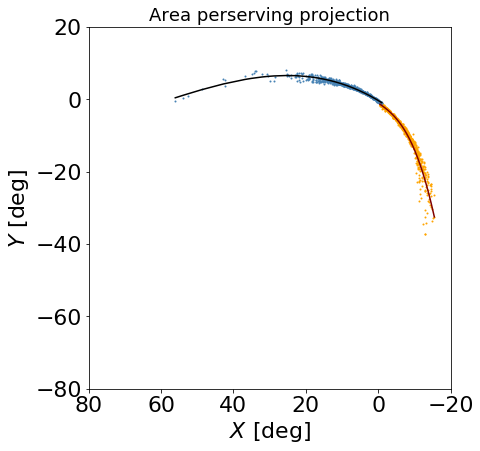

In [2813]:
fig,axes = plt.subplots(1,1,figsize=(7,7))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 22})


axes.set_aspect('equal')
axes.set_xlim(80,-20)
axes.set_ylim(-80,20)

axes.set_title('Area perserving projection', fontsize=18)
axes.scatter(stream_proj_x_sort[sim_lead_index],stream_proj_y_sort[sim_lead_index], s=1, color='orange')
axes.scatter(stream_proj_x_sort[sim_trail_index],stream_proj_y_sort[sim_trail_index], s=1, color='steelblue')

axes.plot(stream_proj_x_sort[sim_lead_index],stream_poly_y_lead, color="maroon") #poly fit to leading arm
axes.plot(stream_proj_x_sort[sim_trail_index],stream_poly_y_trail, color="black") #poly fit to trailing arm

axes.set_xlabel('$X$ [deg]')
axes.set_ylabel('$Y$ [deg]')

fig.tight_layout()

## Find normal,v, and tangential, u, vectors to points along polynomial

For u-vector (tangent)
For any given point,k, along the polynomial, use the values of polynomial surrounding k to find the tangent to the point (i.e. derivative).

For v-vector (normal)
For any given point,k, along the polynomial, use the values of polynomial surrounding k to find the curvature in this point (double derivative) to know the "sign" of curvature and therefore how to place v.

In [2814]:
#Looking at one point, k, along the trailing poly-fit
k_neigh = 1 #look at indeces next surrounding k 
k_index = 900 # will make loop

k_x = stream_proj_x_sort[sim_trail_index][k_index]
k_y = stream_poly_y_trail[k_index]

k_x_neigh = stream_proj_x_sort[sim_trail_index][k_index - k_neigh]
k_y_neigh = stream_poly_y_trail[k_index - k_neigh]

k_x_neigh_neg = stream_proj_x_sort[sim_trail_index][k_index + k_neigh]
k_y_neigh_neg = stream_poly_y_trail[k_index + k_neigh]

#Part of poly fit line to use:
k_poly_x = stream_proj_x_sort[sim_trail_index][k_index-k_neigh:k_index+k_neigh]# part of polynomial that surrounds node k 
k_poly_y = stream_poly_y_trail[k_index-k_neigh:k_index+k_neigh]


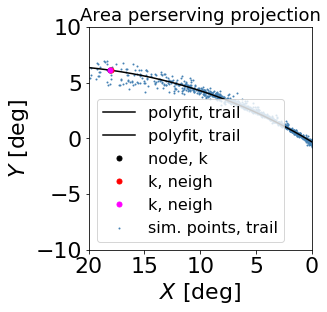

In [2815]:
fig,axes = plt.subplots(1,1,figsize=(5,5))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 16})


axes.set_aspect('equal')
axes.set_xlim(20,0)
axes.set_ylim(-10,10)

axes.set_title('Area perserving projection', fontsize=18)
axes.scatter(stream_proj_x_sort[sim_trail_index],stream_proj_y_sort[sim_trail_index], s=1, color='steelblue', label="sim. points, trail")

#axes.plot(poly_trail_x ,stream_poly_y_trail, color="black", label="polyfit, trail") #poly fit to trailing arm
axes.plot(stream_proj_x_sort[sim_trail_index],stream_poly_y_trail, color="black", label="polyfit, trail") #poly fit to trailing arm
axes.plot(k_poly_x,k_poly_y,color="black", label="polyfit, trail") #poly fit to trailing arm



axes.plot(k_x,k_y, marker="o", markersize=5, color='black', linestyle='none', label="node, k") #poly fit to trailing arm
axes.plot(k_x_neigh,k_y_neigh, marker="o", markersize=5, color='red', linestyle='none', label="k, neigh") #poly fit to trailing arm
axes.plot(k_x_neigh_neg,k_y_neigh_neg, marker="o", markersize=5, color='magenta', linestyle='none', label="k, neigh") #poly fit to trailing arm

axes.set_xlabel('$X$ [deg]')
axes.set_ylabel('$Y$ [deg]')

axes.legend()
fig.tight_layout()

In [2816]:
#Find u - derivative of the part of poly surrounding k
deriv = np.polyder(polyfit_trail)   
print(deriv)
#I already have a point to evaluate in: k_x, and I have it's value k_y
slope_at_node = np.polyval(deriv, k_x)
print(slope_at_node)
ylow = (k_x_neigh_neg - k_x )  * slope_at_node + k_y
yhigh = (k_x_neigh- k_x) * slope_at_node + k_y
#polyfit_trail

[ 2.39600878e-04 -2.98438322e-02  5.98735150e-01]
0.13782756877299907


In [2817]:
polyfit_trail

array([ 7.98669594e-05, -1.49219161e-02,  5.98735150e-01, -3.04037403e-01])

In [2818]:
deriv_2 = np.polyder(deriv) #second derivative 
second_der_at_node = np.polyval(deriv_2, k_x)

In [2819]:
xmin = np.round(k_x) - 3
xmax = np.round(k_x) + 3
ymin = np.round(k_y) - 3
ymax = np.round(k_y) + 3

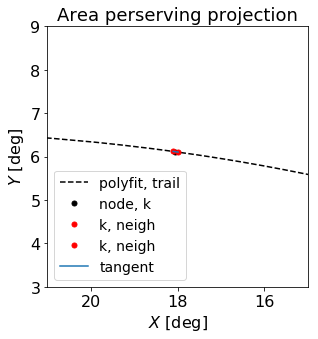

In [2820]:
fig,axes = plt.subplots(1,1,figsize=(5,5))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 16})


axes.set_aspect('equal')
axes.set_xlim(xmax,xmin)
axes.set_ylim(ymin,ymax)

axes.set_title('Area perserving projection', fontsize=18)
axes.plot(stream_proj_x_sort[sim_trail_index],stream_poly_y_trail, color="black", label="polyfit, trail", linestyle='--') #poly fit to trailing arm


axes.plot(k_x,k_y, marker="o", markersize=5, color='black', linestyle='none', label="node, k") #poly fit to trailing arm
axes.plot(k_x_neigh,k_y_neigh, marker="o", markersize=5, color='red', linestyle='none', label="k, neigh") #poly fit to trailing arm
axes.plot(k_x_neigh_neg,k_y_neigh_neg, marker="o", markersize=5, color='red', linestyle='none', label="k, neigh") #poly fit to trailing arm

#axes.plot([k_x,k_x_neigh],[k_y,yhigh], label="tangent") #from node, k
axes.plot([k_x_neigh_neg,k_x_neigh],[ylow,yhigh], label="tangent")


axes.set_xlabel('$X$ [deg]')
axes.set_ylabel('$Y$ [deg]')

axes.legend(loc="lower left", fontsize=14)
fig.tight_layout()

I now have the tangent and sign of the secon derivative: compute u, v unit vectors from node k.

In [2821]:
u = np.array([[0,k_x-k_x_neigh],[0,k_y-yhigh]])
u_norm = u/np.sqrt((np.sum(u**2)))
u_x =  k_x - u_norm[0] 
u_y =  k_y - u_norm[1] 

In [2822]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [2823]:
#Second derivative at node determines which way the v-vector is pointing
sign = 1
if second_der_at_node < 0:
    sign = -1

In [2824]:
v_x2, v_y2 = rotate(origin = (u_x[0],u_y[0]), point = (u_x[1],u_y[1]), angle = sign*np.pi/2)

In [2825]:
v_x = np.array([u_x[0], v_x2])
v_y = np.array([u_y[0], v_y2])

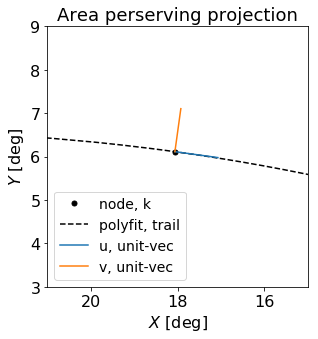

In [2826]:
fig,axes = plt.subplots(1,1,figsize=(5,5))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 16})

axes.set_aspect('equal')
axes.set_xlim(xmax,xmin)
axes.set_ylim(ymin,ymax)

axes.set_title('Area perserving projection', fontsize=18)

axes.plot(k_x,k_y, marker="o", markersize=5, color='black', linestyle='none', label="node, k") #poly fit to trailing arm
axes.plot(stream_proj_x_sort[sim_trail_index],stream_poly_y_trail, color="black", label="polyfit, trail", linestyle='--') #poly fit to trailing arm
axes.plot(u_x,u_y, label='u, unit-vec') #from node, k
axes.plot(v_x,v_y, label='v, unit-vec') #from node, k


axes.set_xlabel('$X$ [deg]')
axes.set_ylabel('$Y$ [deg]')

axes.legend(loc="lower left", fontsize=14)
fig.tight_layout()

## Function that: given "node", k on polynomial fit, returns u,v-vectiors

In [2827]:
def u_v_unitvectors(node_k, polyfit_x, polyfit_y, fit):
    """Given an index at node, k, for a polynimial fit, the function returns a tangential, u, and 
    norm, v, unitvectors at node, k.
    
    "node_k" is and index included in the polyfit_arr. 
    
    "fit" is an array of coecfficients of the polynomial fit.
    "polyfit_x" is the array associated with the polynomial fit. 
    "polyfit_y" is the polynomial fit y-values 


    The function returns nromalized normal, v, and tangent, u, vectors from point at node_k along polyfit.
    
    """

    #Along the  poly-fit, k_index is the index of the node of interest, 
    #and k_neigh is it's nearest point on poly
    k_neigh = 1 
    k_index = node_k 


    #Computes the derivative from the polynomial fit coefficients
    deriv = np.polyder(fit)   
    slope_at_node = np.polyval(deriv, polyfit_x[k_index])
    
    #Sec. deriv determines which way the v-vector is pointing
    #Sign: is fed into the rotation-function below
    deriv_2 = np.polyder(deriv) 
    second_der_at_node = np.polyval(deriv_2, polyfit_x[k_index])
    sign = 1
    if second_der_at_node < 0:
        sign = -1


    #The x and y-value of the the tangent line for the u-vector 
    x_neigh = polyfit_x[k_index] - polyfit_x[k_index - k_neigh]
    y_neigh = polyfit_y[k_index] - ((polyfit_x[k_index - k_neigh]\
                                     - polyfit_x[k_index]) * slope_at_node + polyfit_y[k_index] )

 
    #tangential norm vec. 
    u = np.array([[0, x_neigh],[0, y_neigh]])
    u_norm = u/np.sqrt((np.sum(u**2)))
    u_x =  polyfit_x[k_index] - u_norm[0] 
    u_y =  polyfit_y[k_index] - u_norm[1] 
    u = np.array([u_x,u_y]) #normalized
    
    
    #normal-vector to node, k normalized 
    #calls "rotate function"
    v_x2, v_y2 = rotate(origin = (u_x[0],u_y[0]), point = (u_x[1],u_y[1]), angle = sign*np.pi/2)
    v_x = np.array([u_x[0], v_x2]) #same origin as u-vev
    v_y = np.array([u_y[0], v_y2]) #same origin as u-vev
    v = np.array([v_x,v_y]) 
    
    return u, v

## Gaussians along stream 
Vary "size" (width), amoplitude (density) and maybe position as 

In [2828]:
def covarience(u, h, s_k):
    """Given tangent normalized vector at a given node k,
    this function takes the "bandwidth", h, and the function, s_k, 
    and returns the covarience matrix"""
    Ck_prim = np.zeros([2,2])
    Ck_prim[0,0] = h**2
    Ck_prim[1,1] = s_k**2
    
 #   print(u)
    theta = np.arctan2(u[1,0] -u[1,1] ,u[0,0] - u[0,1]) #might need to flip this when not in "flipped coord. sys"
  #  print(theta)

    R = np.zeros([2,2]) #rotation from u,v to x,y (sky-tangent-plane, area conserved )
    R[0,0] = np.cos(theta)
    R[0,1] = - np.sin(theta)
    R[1,0] = np.sin(theta)
    R[1,1] = np.cos(theta)
    
    Ck = R @ Ck_prim @ R.T
   # print(Ck.shape)
    return Ck

In [2829]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

In [2830]:
#u[:,:,0]

In [2831]:
def ln_density(xy, nodes, s_k, a_k, h, u):
    # TODO: compute C at location of each node, store as "Cs" array or list
    
    ln_dens = np.zeros([len(nodes),len(xy)])
    for k in range(len(nodes)):
      #  print(h)
        C = covarience(u[:,:,k], h, s_k[k])
        ln_dens[k] = multivariate_normal.logpdf(xy,nodes[k],C) + np.log(a_k[k]) 
        
                       
    return logsumexp(ln_dens,axis=0)

## Call functions for Gaussian mixture model

In [2832]:
 ### Leading arm #####
polyfit_lead_x = np.linspace(-20,0,1000)
polyfit_lead_y = np.poly1d(polyfit_lead)(polyfit_lead_x)

#### Trailing Arm ########
#Redefine my polyfit_x, polyfit_y
polyfit_trail_x = np.linspace(0,80,1000)
polyfit_trail_y = np.poly1d(polyfit_trail)(polyfit_trail_x)


In [2833]:
np.linspace(1,len(polyfit_lead_x)-1,10, dtype=int)

array([  1, 111, 222, 333, 444, 555, 666, 777, 888, 999])

In [2834]:
np.arange(1,len(polyfit_lead_x)-1,np.int(len(polyfit_lead_x)/10.))
#z = np.array([ 1, 101, 201, 301, 401, 501,  651, 901])
#z= np.geomspace(50,len(polyfit_lead_x)-1,100, dtype=int)
#z

array([  1, 101, 201, 301, 401, 501, 601, 701, 801, 901])

In [2835]:
## Here's the array of "indices"/node placements
# Space out various nodes and save their positions in "nodes"-array 
i = 0
nodes_arr = np.arange(1,len(polyfit_lead_x)-1,np.int(len(polyfit_lead_x)/10.))
#nodes_arr = z
nodes = np.zeros([len(nodes_arr),2])
for k in nodes_arr:
    nodes[i,:] = np.array([polyfit_lead_x[k],polyfit_lead_y[k]])
    i = i + 1
    
    
####TRAILING####
i = 0
nodes_arr_trail = np.arange(1,len(polyfit_trail_x)-1,np.int(len(polyfit_trail_x)/10.))
nodes_trail = np.zeros([len(nodes_arr_trail),2])
for k in nodes_arr_trail:
    nodes_trail[i,:] = np.array([polyfit_trail_x[k],polyfit_trail_y[k]])
    i = i + 1

In [2836]:
nodes

array([[-19.97997998, -57.59944259],
       [-17.97797798, -45.00295593],
       [-15.97597598, -34.5487653 ],
       [-13.97397397, -26.01131634],
       [-11.97197197, -19.1650547 ],
       [ -9.96996997, -13.78442604],
       [ -7.96796797,  -9.64387601],
       [ -5.96596597,  -6.51785026],
       [ -3.96396396,  -4.18079444],
       [ -1.96196196,  -2.40715419]])

In [2837]:
### Call u/v-function to make u-vector of length based on number of nodes/indices to feed ln_density
u = np.zeros([2,2,len(nodes_arr)])
v = np.zeros([2,2,len(nodes_arr)])
for k in range(len(nodes_arr)):
    u[:,:,k],v[:,:,k] = u_v_unitvectors(node_k = nodes_arr[k] , \
                        polyfit_x = polyfit_lead_x, polyfit_y = polyfit_lead_y, fit = polyfit_lead)
    
    
### Call u/v-function to make u-vector of length based on number of nodes/indices to feed ln_density
u_trail = np.zeros([2,2,len(nodes_arr_trail)])
v_trail = np.zeros([2,2,len(nodes_arr_trail)])
for k in range(len(nodes_arr_trail)):
    u_trail[:,:,k],v_trail[:,:,k] = u_v_unitvectors(node_k = nodes_arr_trail[k] , \
                        polyfit_x = polyfit_trail_x, polyfit_y = polyfit_trail_y, fit = polyfit_trail)    

In [2838]:
x, y = np.meshgrid(np.linspace(-30, 80, 128),
                   np.linspace(-80, 30, 128))
xy = np.stack((x.ravel(), y.ravel())).T

In [2839]:
# this below should be executable 
K = len(nodes)
derp = ln_density(xy, nodes = nodes, s_k = np.ones(K), a_k = np.ones(K), h = 1, u = u)


#trailinf
K = len(nodes_trail)
derp_trail = ln_density(xy, nodes = nodes_trail, s_k = np.ones(K), a_k = np.ones(K), h = 1, u = u_trail)

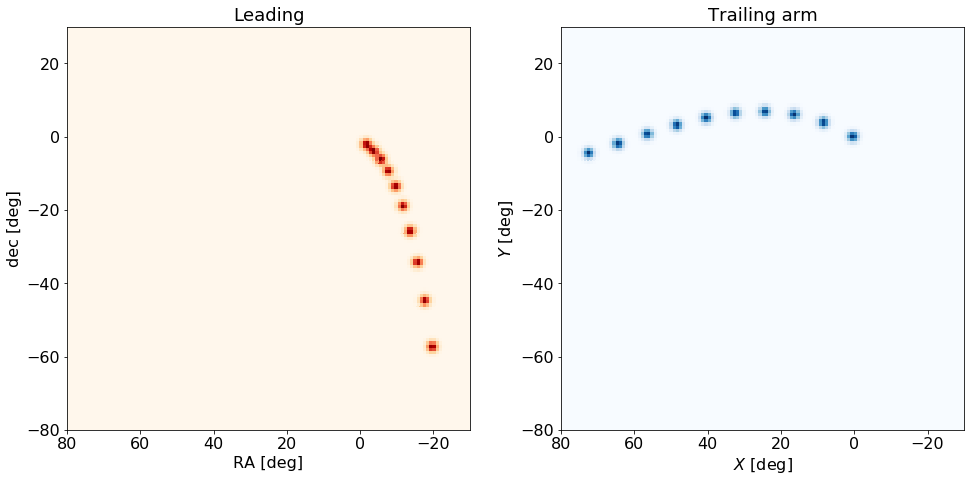

In [2840]:
fig,axes = plt.subplots(1,2,figsize=(14,7))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 22})

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[0].set_xlim(80,-30)
axes[1].set_xlim(80,-30)
axes[0].set_ylim(-80,30)
axes[1].set_ylim(-80,30)

axes[0].set_title('Leading', fontsize=18)
axes[0].pcolormesh(x, y, np.exp(derp.reshape(x.shape) - np.max(derp)),cmap ='OrRd')
#axes[0].plot(polyfit_lead_x[nodes_arr] ,polyfit_lead_y[nodes_arr] , linestyle='--',color='black')#,marker='o', label='node_k')

axes[0].set_xlabel('RA [deg]')
axes[0].set_ylabel('dec [deg]')

axes[1].set_title('Trailing arm', fontsize=18)
axes[1].pcolormesh(x, y, np.exp(derp_trail.reshape(x.shape) - np.max(derp_trail)),cmap ='Blues')
#axes[1].plot(polyfit_trail_x[nodes_arr_trail] ,polyfit_trail_y[nodes_arr_trail] , linestyle='--',color='black')#,marker='o', label='node_k')

axes[1].set_xlabel('$X$ [deg]')
axes[1].set_ylabel('$Y$ [deg]')

fig.tight_layout()


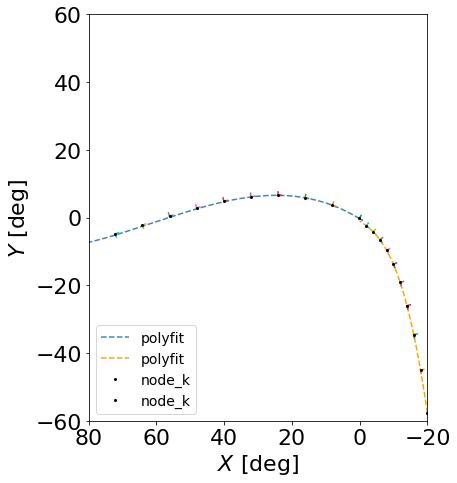

In [2841]:
#Checking I populate the correct "gaussian"
fig,axes = plt.subplots(1,1,figsize=(7,7))#, sharey=True, sharex=True)
matplotlib.rcParams.update({'font.size': 16})

# xmin = np.round(polyfit_x[node_k]) - 3
# xmax = np.round(polyfit_x[node_k]) + 3
# ymin = np.round(polyfit_y[node_k]) - 3
# ymax = np.round(polyfit_y[node_k]) + 3

axes.set_xlim(80,-20)
axes.set_ylim(-60,60)

axes.set_aspect('equal')
# axes.set_xlim(xmax,xmin)
# axes.set_ylim(ymin,ymax)

#axes.scatter(test_Ck.T[0],test_Ck.T[1], s=0.002, zorder = -100, color='g')
axes.plot(polyfit_x ,polyfit_y , linestyle='--', label='polyfit', color='steelblue')
axes.plot(polyfit_lead_x ,polyfit_lead_y , linestyle='--', label='polyfit', color='orange')

axes.plot(u[0],u[1])#, label='u, unit-vec', c='red') #from node, k
axes.plot(v[0],v[1])#, label='v, unit-vec') #from node, k

axes.plot(u_trail[0],u_trail[1])#, label='u, unit-vec', c='red') #from node, k
axes.plot(v_trail[0],v_trail[1])#, label='v, unit-vec') #from node, k

axes.plot(polyfit_trail_x[nodes_arr_trail] ,polyfit_trail_y[nodes_arr_trail] , linestyle='none',color='black',marker='o', label='node_k', markersize=2)
axes.plot(polyfit_lead_x[nodes_arr] ,polyfit_lead_y[nodes_arr] , linestyle='none',color='black',marker='o', label='node_k', markersize=2)

axes.set_xlabel('$X$ [deg]')
axes.set_ylabel('$Y$ [deg]')

axes.legend(loc="lower left", fontsize=14)
fig.tight_layout()